# Hospital Mortality Prediction

In [46]:
import pandas as pd
import numpy as np
import random as rnd
import pprint
from itertools import cycle, islice
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy.stats import multivariate_normal

from sklearn.model_selection import train_test_split
from sklearn import model_selection, preprocessing
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV,KFold, cross_val_predict, StratifiedKFold, train_test_split, learning_curve, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC 
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
from sklearn.utils.fixes import signature

from sklearn.decomposition import PCA

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import tensorflow as tf

from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils

import warnings
warnings.filterwarnings('ignore')
import os

Using TensorFlow backend.


In [5]:
# Loading dataset

data = pd.read_csv('mimic3c.csv')

With id (58976, 28)


In [7]:
data.head()

,hadm_id,gender,age,LOSdays,admit_type,admit_location,AdmitDiagnosis,insurance,religion,marital_status,...,NumMicroLabs,NumNotes,NumOutput,NumRx,NumProcEvents,NumTransfers,NumChartEvents,ExpiredHospital,TotalNumInteract,LOSgroupNum
0,100001,F,35,6.17,EMERGENCY,CLINIC REFERRAL/PREMATURE,DIABETIC KETOACIDOSIS,Private,PROTESTANT QUAKER,DIVORCED,...,0.65,0.05,5.19,14.91,1.13,0.65,398.70,0,493.89,2
1,100003,M,59,4.04,EMERGENCY,EMERGENCY ROOM ADMIT,UPPER GI BLEED,Private,NOT SPECIFIED,SINGLE,...,1.24,1.59,5.45,7.18,0.99,1.24,373.02,0,465.71,2
2,100006,F,48,12.04,EMERGENCY,EMERGENCY ROOM ADMIT,COPD FLARE,Private,NOT SPECIFIED,SINGLE,...,0.33,0.15,4.15,6.23,0.00,0.33,286.21,0,344.00,4
3,100007,F,73,7.29,EMERGENCY,EMERGENCY ROOM ADMIT,BOWEL OBSTRUCTION,Private,JEWISH,MARRIED,...,0.69,0.17,9.05,11.52,0.00,0.96,526.06,0,603.05,2
4,100009,M,60,4.88,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,CORONARY ARTERY DISEASE,Private,CATHOLIC,MARRIED,...,0.61,0.34,16.19,25.00,2.87,2.05,554.92,0,679.84,2


In [9]:
data_full = data.drop('hadm_id', 1)
print("No id",data_full.shape)

No id (58976, 27)


# Data Description

In [10]:
print(data_full.shape)
data_full.info()
data_full.describe()

(58976, 27)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 27 columns):
gender              58976 non-null object
age                 58976 non-null int64
LOSdays             58976 non-null float64
admit_type          58976 non-null object
admit_location      58976 non-null object
AdmitDiagnosis      58951 non-null object
insurance           58976 non-null object
religion            58518 non-null object
marital_status      48848 non-null object
ethnicity           58976 non-null object
NumCallouts         58976 non-null float64
NumDiagnosis        58976 non-null float64
NumProcs            58976 non-null float64
AdmitProcedure      58976 non-null object
NumCPTevents        58976 non-null float64
NumInput            58976 non-null float64
NumLabs             58976 non-null float64
NumMicroLabs        58976 non-null float64
NumNotes            58976 non-null float64
NumOutput           58976 non-null float64
NumRx               58976 non-

,age,LOSdays,NumCallouts,NumDiagnosis,NumProcs,NumCPTevents,NumInput,NumLabs,NumMicroLabs,NumNotes,NumOutput,NumRx,NumProcEvents,NumTransfers,NumChartEvents,ExpiredHospital,TotalNumInteract,LOSgroupNum
count,58976.000000,58976.000000,58976.000000,58976.00000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000
mean,53.005884,10.114955,0.099374,2.67596,0.785599,1.074118,30.379017,46.421124,1.219913,6.464789,7.111594,9.593702,0.691903,1.093313,528.505172,0.099261,636.115579,2.360248
std,26.028120,12.456231,0.163437,8.26559,3.558090,2.027148,62.430163,76.061561,4.236693,106.709903,7.551822,12.601338,2.117615,3.169441,640.250063,0.299014,783.938087,1.130337
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,43.000000,3.710000,0.000000,0.82000,0.210000,0.000000,4.850000,26.980000,0.160000,0.140000,1.750000,4.330000,0.000000,0.380000,207.410000,0.000000,267.407500,1.000000
50%,59.000000,6.460000,0.000000,1.41000,0.420000,0.970000,13.990000,38.520000,0.510000,0.330000,5.310000,8.370000,0.000000,0.650000,417.875000,0.000000,497.335000,2.000000
75%,73.000000,11.790000,0.160000,2.40000,0.710000,1.560000,34.360000,50.860000,1.350000,0.770000,10.490000,12.270000,0.880000,1.060000,700.302500,0.000000,811.382500,3.000000
max,89.000000,294.630000,4.760000,450.00000,275.000000,225.000000,6825.000000,5175.000000,375.000000,7500.000000,375.000000,750.000000,100.000000,125.000000,49325.000000,1.000000,68600.000000,4.000000


# Distributions

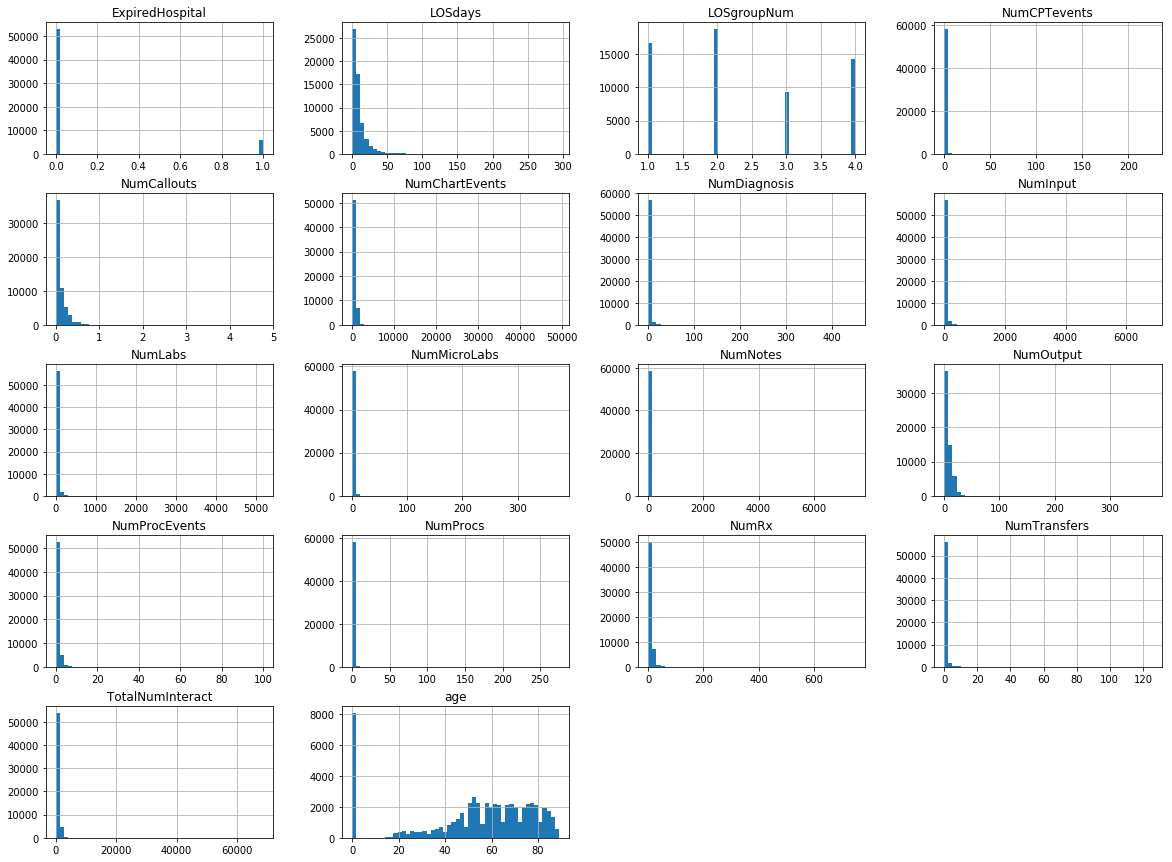

In [11]:
data_full.hist(bins=50, figsize=(20,15))
plt.show()

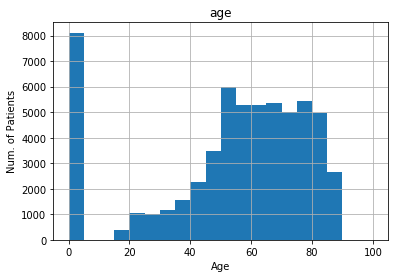

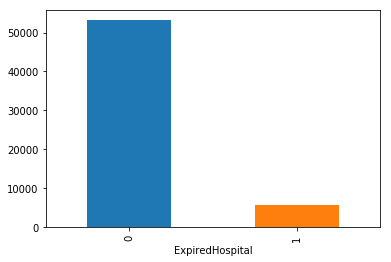

In [12]:
age_histogram = data_full.hist(column='age', bins=20, range=[0, 100])
for ax in age_histogram.flatten():
    ax.set_xlabel("Age")
    ax.set_ylabel("Num. of Patients")
plt.show()
data_full.groupby('ExpiredHospital').size().plot.bar()
plt.show()

In [13]:
# Label = ExpiredHospital
y = data_full['ExpiredHospital']
X = data_full.drop('ExpiredHospital', 1)

X = X.drop('LOSdays', 1)
X = X.drop('LOSgroupNum', 1)
X = X.drop('AdmitDiagnosis', 1)
X = X.drop('AdmitProcedure', 1)
X = X.drop('marital_status', 1)
X = X.drop('ethnicity', 1)
X = X.drop('religion', 1)
X = X.drop('insurance', 1)

print("y - Labels", y.shape)
print("X - No Label No id ", X.shape)
print(X.columns)

y - Labels (58976,)
X - No Label No id  (58976, 18)
Index(['gender', 'age', 'admit_type', 'admit_location', 'NumCallouts',
       'NumDiagnosis', 'NumProcs', 'NumCPTevents', 'NumInput', 'NumLabs',
       'NumMicroLabs', 'NumNotes', 'NumOutput', 'NumRx', 'NumProcEvents',
       'NumTransfers', 'NumChartEvents', 'TotalNumInteract'],
      dtype='object')


In [14]:
# Check that all X columns have no missing values
X.info()
X.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 18 columns):
gender              58976 non-null object
age                 58976 non-null int64
admit_type          58976 non-null object
admit_location      58976 non-null object
NumCallouts         58976 non-null float64
NumDiagnosis        58976 non-null float64
NumProcs            58976 non-null float64
NumCPTevents        58976 non-null float64
NumInput            58976 non-null float64
NumLabs             58976 non-null float64
NumMicroLabs        58976 non-null float64
NumNotes            58976 non-null float64
NumOutput           58976 non-null float64
NumRx               58976 non-null float64
NumProcEvents       58976 non-null float64
NumTransfers        58976 non-null float64
NumChartEvents      58976 non-null float64
TotalNumInteract    58976 non-null float64
dtypes: float64(14), int64(1), object(3)
memory usage: 8.1+ MB


,age,NumCallouts,NumDiagnosis,NumProcs,NumCPTevents,NumInput,NumLabs,NumMicroLabs,NumNotes,NumOutput,NumRx,NumProcEvents,NumTransfers,NumChartEvents,TotalNumInteract
count,58976.000000,58976.000000,58976.00000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000,58976.000000
mean,53.005884,0.099374,2.67596,0.785599,1.074118,30.379017,46.421124,1.219913,6.464789,7.111594,9.593702,0.691903,1.093313,528.505172,636.115579
std,26.028120,0.163437,8.26559,3.558090,2.027148,62.430163,76.061561,4.236693,106.709903,7.551822,12.601338,2.117615,3.169441,640.250063,783.938087
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,43.000000,0.000000,0.82000,0.210000,0.000000,4.850000,26.980000,0.160000,0.140000,1.750000,4.330000,0.000000,0.380000,207.410000,267.407500
50%,59.000000,0.000000,1.41000,0.420000,0.970000,13.990000,38.520000,0.510000,0.330000,5.310000,8.370000,0.000000,0.650000,417.875000,497.335000
75%,73.000000,0.160000,2.40000,0.710000,1.560000,34.360000,50.860000,1.350000,0.770000,10.490000,12.270000,0.880000,1.060000,700.302500,811.382500
max,89.000000,4.760000,450.00000,275.000000,225.000000,6825.000000,5175.000000,375.000000,7500.000000,375.000000,750.000000,100.000000,125.000000,49325.000000,68600.000000


# Expired Hospital, Admit Type

In [50]:
a = data_full.groupby('ExpiredHospital').size()

In [57]:
b = [0,1]

In [60]:
y_pos = np.arange(len(b))

In [58]:
performance = list(a)

In [59]:
performance

[53122, 5854]

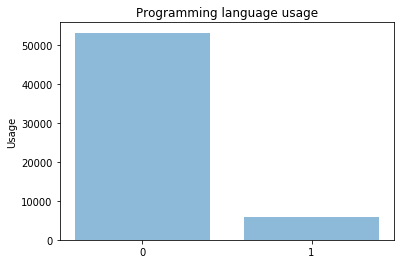

In [62]:
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, b)
plt.ylabel('Usage')
plt.title('Programming language usage')

plt.show()

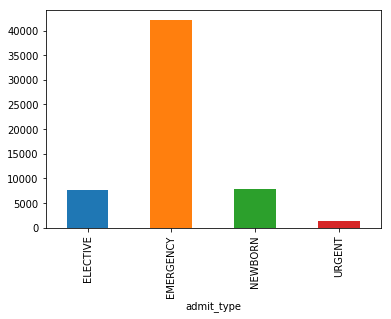

In [63]:
data_full.groupby('admit_type').size().plot.bar()
plt.show()

In [17]:
# MAP Text to Numerical Data with one-hot-encoding to convert categorical features to numerical

print(X.shape)
categorical_columns = [
                    'gender',                     
                    'admit_type',
                    'admit_location'
                      ]
for col in categorical_columns:
    #if the original column is present replace it with a one-hot
    if col in X.columns:
        one_hot_encoded = pd.get_dummies(X[col])
        X = X.drop(col, axis=1)
        X = X.join(one_hot_encoded, lsuffix='_left', rsuffix='_right')
        
print(X.shape)

(58976, 18)
(58976, 30)


In [19]:
print(data_full.shape)
print(X.shape)

XnotNorm = X.copy()
print('XnotNorm ', XnotNorm.shape)

#yFI = data_full.expired_icu
ynotNorm = y.copy()
print('ynotNorm ', ynotNorm.shape)

(58976, 27)
(58976, 30)
XnotNorm  (58976, 30)
ynotNorm  (58976,)


In [20]:
# Normalize X

x = XnotNorm.values #returns a numpy array
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x)
XNorm = pd.DataFrame(x_scaled, columns=XnotNorm.columns)
print(XNorm)


            age  NumCallouts  NumDiagnosis  NumProcs  NumCPTevents   NumInput  \
0     -0.691792     0.370949     -0.010400 -0.220794      0.111429  -0.084239   
1      0.230296     0.921627     -0.053954  0.057447      0.446879  -0.268607   
2     -0.192328    -0.608032     -0.233011 -0.173015     -0.120425  -0.303045   
3      0.768180     1.900608     -0.240270 -0.144910     -0.189488  -0.161446   
4      0.268716    -0.608032      0.122683  0.009668      0.580072  -0.158403   
5      0.038194     0.799254     -0.185827 -0.029679      0.372883  -0.380573   
6     -1.229676    -0.179728     -0.206395  0.071500      1.014183   0.512593   
7      0.537658     0.003831     -0.191877 -0.108373      0.007835  -0.173620   
8     -0.153907    -0.608032      1.212754  1.117014      1.033916  -0.486612   
9      0.076615    -0.608032     -0.108397  0.006858      0.668868  -0.071265   
10    -0.999154    -0.608032      1.120806  0.619551     -0.529871  -0.175862   
11     0.076615     0.126204

In [21]:
# SPLIT into Train & Test

X_train, X_test, y_train, y_test = train_test_split(XNorm, y, test_size=0.2, random_state=42)
print ('X_train: ', X_train.shape)
print ('X_test: ', X_test.shape)
print ('y_train: ', y_train.shape)
print ('y_test: ', y_test.shape)

X_train:  (47180, 30)
X_test:  (11796, 30)
y_train:  (47180,)
y_test:  (11796,)


In [22]:
# Test Models and evaluation metric
seed = 7
scoring = 'accuracy' 

# Spot Check Algorithms
Mymodels = []
Mymodels.append(('LogReg', LogisticRegression()))
Mymodels.append(('RandomForest', RandomForestClassifier()))
Mymodels.append(('SGDclassifier', SGDClassifier()))
Mymodels.append(('KNearestNeighbors', KNeighborsClassifier()))
Mymodels.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
#Mymodels.append(('GaussianNB', GaussianNB()))
#Mymodels.append(('SVM', SVC()))

# Evaluate each model in turn
results = []
names = []
for name, model in Mymodels:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg) 

LogReg: 0.930203 (0.003467)
RandomForest: 0.934082 (0.002113)
SGDclassifier: 0.922276 (0.004204)
KNearestNeighbors: 0.928148 (0.002909)
DecisionTreeClassifier: 0.900297 (0.004776)


In [23]:
# Optimize hyper params for one model

model = RandomForestClassifier()

param_grid = [{},]

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(XNorm, y)

print(grid_search.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [24]:
# Set the model according to above results

model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [25]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Error")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = 1-np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = 1-np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\lhe-faisalm\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

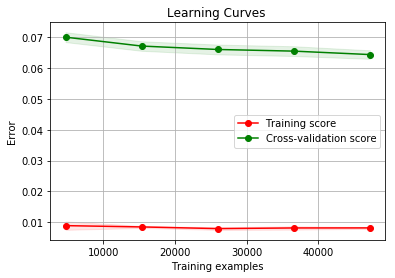

In [26]:
# LEARNING CURVES Train / Validation

title = "Learning Curves "
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(model, title, XNorm, y, cv=cv, n_jobs=5)

In [27]:
# Model FINAL fit and evaluation on test

model.fit(X_train, y_train)
final_predictions = model.predict(X_test)

#final_acc = accuracy(y_test, final_predictions)
# Confusion matrix

conf_mx = confusion_matrix(y_test, final_predictions)

TN = conf_mx[0,0]
FP = conf_mx[0,1]
FN = conf_mx[1,0]
TP = conf_mx[1,1]

print ('TN: ', TN)
print ('FP: ', FP)
print ('FN: ', FN)
print ('TP: ', TP)

recall = TP/(TP+FN)
precision = TP/(TP+FP)

print (recall, precision)

TN:  10525
FP:  104
FN:  643
TP:  524
0.4490145672664953 0.8343949044585988


In [28]:
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,
                          normalize=False):
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


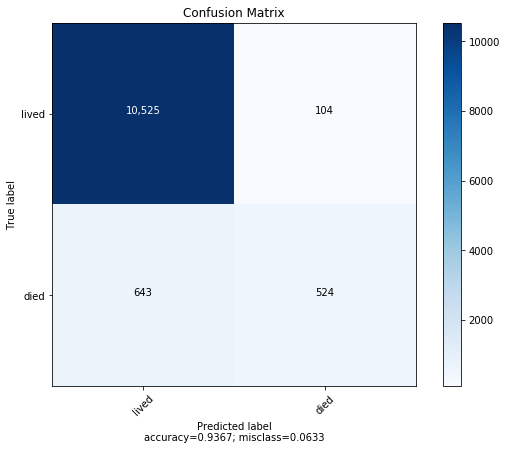

In [29]:
plot_confusion_matrix(conf_mx, 
                      normalize    = False,
                      target_names = ['lived', 'died'],
                      title        = "Confusion Matrix")

In [30]:
print ('precision ',round(precision_score(y_test, final_predictions),4))
print ('recall ',round(recall_score(y_test, final_predictions) ,4))
print ('accuracy ',round(accuracy_score(y_test, final_predictions),4))
print ('F1 score ',round(f1_score(y_test, final_predictions),4))

precision  0.8344
recall  0.449
accuracy  0.9367
F1 score  0.5838


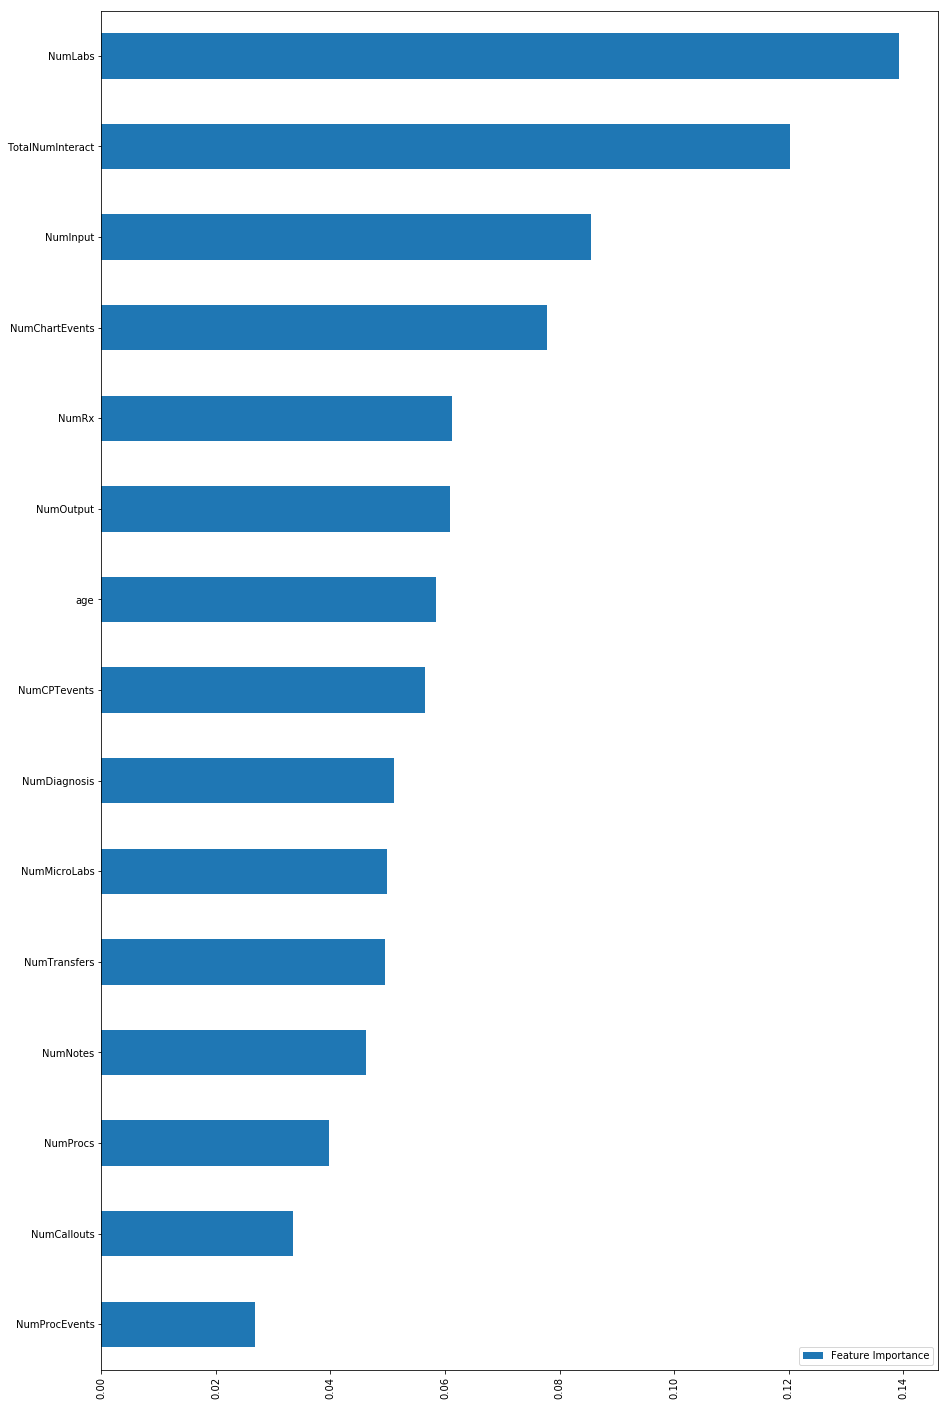

In [31]:
# FEATURE IMPORTANCE 

trainFinalFI = XNorm
yFinalFI = y
model.fit(trainFinalFI,yFinalFI)

FI_model = pd.DataFrame({"Feature Importance":model.feature_importances_,}, index=trainFinalFI.columns)
FI_model[FI_model["Feature Importance"] > 0.01].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.xticks(rotation=90)
plt.show()

In [32]:
# List of important features for model
FI_model = pd.DataFrame({"Feature Importance":model.feature_importances_,}, index=trainFinalFI.columns)
FI_model=FI_model.sort_values('Feature Importance', ascending = False)
print(FI_model[FI_model["Feature Importance"] > 0.0025])

                           Feature Importance
NumLabs                              0.139215
TotalNumInteract                     0.120267
NumInput                             0.085419
NumChartEvents                       0.077836
NumRx                                0.061284
NumOutput                            0.060899
age                                  0.058374
NumCPTevents                         0.056572
NumDiagnosis                         0.051095
NumMicroLabs                         0.049911
NumTransfers                         0.049594
NumNotes                             0.046133
NumProcs                             0.039677
NumCallouts                          0.033398
NumProcEvents                        0.026901
EMERGENCY                            0.006975
F                                    0.005733
EMERGENCY ROOM ADMIT                 0.005292
M                                    0.005127
TRANSFER FROM HOSP/EXTRAM            0.004756
CLINIC REFERRAL/PREMATURE         

AUC: 0.720


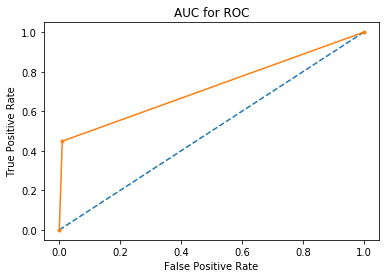

In [33]:
# AUC/ROC curves should be used when there are roughly equal numbers of observations for each class
# Precision-Recall curves should be used when there is a moderate to large class imbalance

# calculate AUC
auc = roc_auc_score(y_test, final_predictions)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, final_predictions)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.title('AUC for ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

f1=0.584


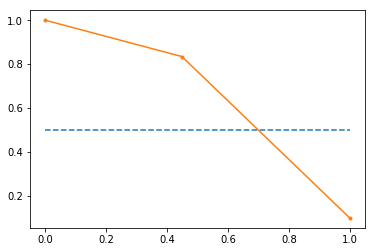

In [34]:
# Modify the raw final_predictions - prediction probs into 0 and 1

Preds = final_predictions.copy()
#print(len(Preds))
#print(Preds)
Preds[ np.where( Preds >= 0.5 ) ] = 1
Preds[ np.where( Preds < 0.5 ) ] = 0

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, Preds)
# calculate F1 score
f1 = f1_score(y_test, Preds)
print('f1=%.3f' % (f1))
# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the roc curve for the model
plt.plot(recall, precision, marker='.')
# show the plot
plt.show()

# NN

In [36]:
# NN MODEL

# Use of DROPOUT
model = models.Sequential()
model.add(layers.Dense(2048, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(30,)))
#model.add(layers.BatchNormalization())
model.add(layers.Dense(2048, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2048, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
print(model.summary())

# FIT / TRAIN model

NumEpochs = 10
BatchSize = 16

model.compile(optimizer=optimizers.Adam(lr=1e-5), loss='binary_crossentropy', metrics=['binary_accuracy'])
history = model.fit(X_train, y_train, epochs=NumEpochs, batch_size=BatchSize, validation_data=(X_test, y_test))

results = model.evaluate(X_test, y_test)
print("_"*100)
print("Test Loss and Accuracy")
print("results ", results)
history_dict = history.history
history_dict.keys()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 2048)              63488     
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 2049      
Total params: 8,458,241
Trainable params: 8,458,241
Non-trainable params: 0
_________________________________________________________________


dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])

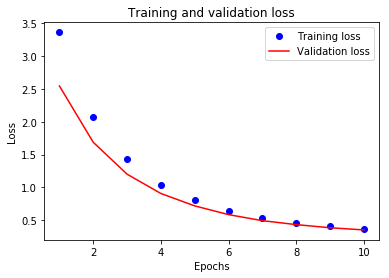

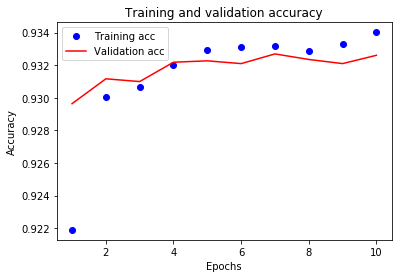

In [37]:
# VALIDATION LOSS curves

plt.clf()
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history_dict['loss']) + 1))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# VALIDATION ACCURACY curves

plt.clf()
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']
epochs = range(1, (len(history_dict['binary_accuracy']) + 1))
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [38]:
# Final Fit / Predict

# NOTE final_predictions is a list of probabilities
#model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
#history = model.fit(X_train, y_train, epochs=NumEpochs, batch_size=BatchSize)

final_predictions = model.predict(X_test)

In [39]:
# Modify the raw final_predictions - prediction probs into 0 and 1

Preds = final_predictions.copy()
#print(len(Preds))
#print(Preds)
Preds[ np.where( Preds >= 0.5 ) ] = 1
Preds[ np.where( Preds < 0.5 ) ] = 0
#print(Preds)

In [40]:

# Confusion matrix

conf_mx = confusion_matrix(y_test, Preds)

TN = conf_mx[0,0]
FP = conf_mx[0,1]
FN = conf_mx[1,0]
TP = conf_mx[1,1]

print ('TN: ', TN)
print ('FP: ', FP)
print ('FN: ', FN)
print ('TP: ', TP)

recall = TP/(TP+FN)
precision = TP/(TP+FP)

print (recall, precision)

TN:  10439
FP:  190
FN:  605
TP:  562
0.48157669237360756 0.7473404255319149


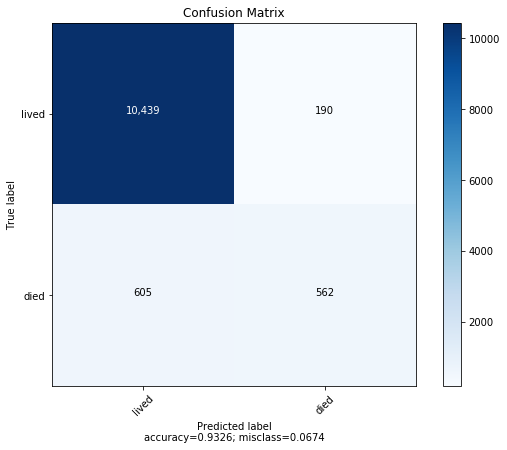

In [41]:
plot_confusion_matrix(conf_mx, 
                      normalize    = False,
                      target_names = ['lived', 'died'],
                      title        = "Confusion Matrix")

In [42]:
print ('precision ',precision_score(y_test, Preds))
print ('recall ',recall_score(y_test, Preds) )
print ('accuracy ',accuracy_score(y_test, Preds))
print ('F1 score ',f1_score(y_test, Preds))

precision  0.7473404255319149
recall  0.48157669237360756
accuracy  0.9326042726347915
F1 score  0.5857217300677436


AUC: 0.732


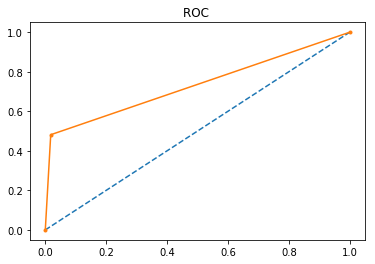

In [43]:
# AUC/ROC curves should be used when there are roughly equal numbers of observations for each class
# Precision-Recall curves should be used when there is a moderate to large class imbalance

# calculate AUC
auc = roc_auc_score(y_test, Preds)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, Preds)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.title('ROC ')
# show the plot
plt.show()

f1=0.586 ap=0.411


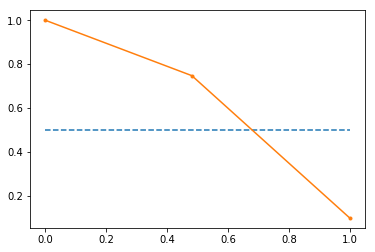

In [44]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, Preds)
# calculate F1 score
f1 = f1_score(y_test, Preds)
# calculate precision-recall AUC
#auc = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(y_test, Preds)
print('f1=%.3f ap=%.3f' % (f1, ap))
# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the roc curve for the model
plt.plot(recall, precision, marker='.')
# show the plot
plt.show()